In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import seaborn as sns
from pylab import rcParams
from collections import defaultdict
from scipy.optimize import curve_fit
import sys
import warnings
import yfinance as yf
warnings.simplefilter("ignore")

# Data Exploration

In [2]:
def download_data(symbols, names, path = 'data',):
    if not os.path.exists(path):
        os.mkdir(path)
    for s,name in zip(symbols,names):
        data = yf.Ticker(s).history("Max")
        data.to_csv(path+'/'+name+'.csv')
        print('{:<15}\tlength:{}'.format(name, len(data)))
    print('Done!')

In [3]:
path = 'data'
datasets_original_test = ['^GSPC', '^DJI', '^NDX', '^N225', '000001.SS', '^HSI', '^BSESN', \
                                  '^GDAXI', '^SSMI', '^MXX', '^BVSP']
dataset_names_test = ['S&P 500', 'DJ', 'NDX', 'N225', 'SSE', 'HSI', 'BSESN', 'DAX', \
                                 'SMI', 'MXX', 'BVSP']

In [4]:
# download_data(symbols=datasets_original_test,names=dataset_names_test,path=path)

Correlations of daily returns between datasets:


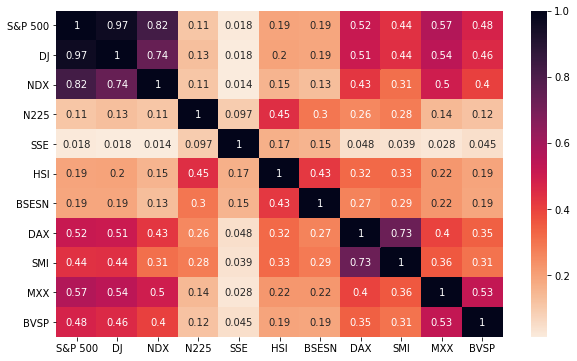

In [5]:
datasets_test = []
for d in dataset_names_test :
    data_original = pd.read_csv(path+'/'+d+'.csv', index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y-%m-%d')
    data_ch = data_original['Close'].pct_change()
    datasets_test.append(data_ch)
df_returns = pd.concat(datasets_test, axis=1, join_axes=[datasets_test[0].index])
df_returns.columns = dataset_names_test
corr = df_returns.corr()
print('Correlations of daily returns between datasets:')
rcParams['figure.figsize'] = 10, 6
ax = sns.heatmap(corr, annot=True, cmap='rocket_r')

Correlations of daily returns between datasets (non-correlated datasets):


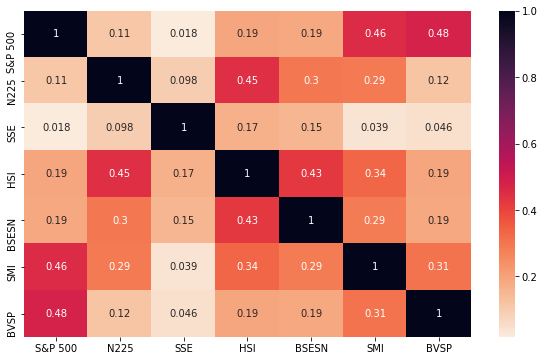

In [6]:
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv', \
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
datasets = []
for d in dataset_names:
    data_original = pd.read_csv(path+'/'+d+'.csv', index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y-%m-%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)
datasets[5] = datasets[5].loc['1990-11-09':,:]   # SMI has much missing data before 11/9/90

df_ch = [d['ch'] for d in datasets]
df_returns = pd.concat(df_ch, axis=1, join_axes=[datasets[0].index])
df_returns.columns = dataset_names
corr = df_returns.corr()
print('Correlations of daily returns between datasets (non-correlated datasets):')
ax = sns.heatmap(corr, annot=True, cmap='rocket_r')

#### Distribution of prices, daily returns, drawdowns

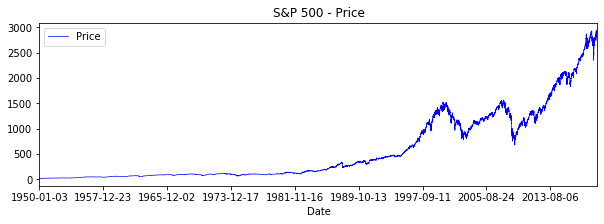

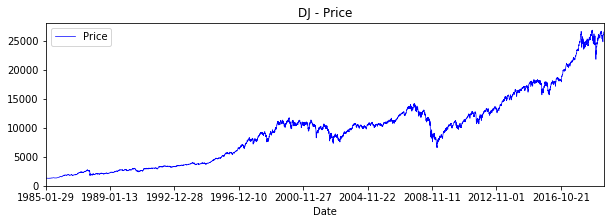

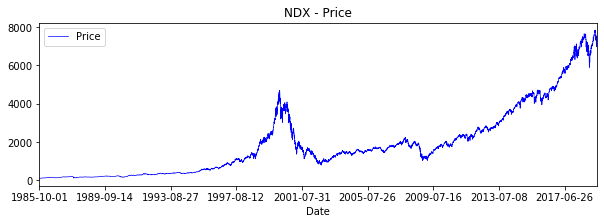

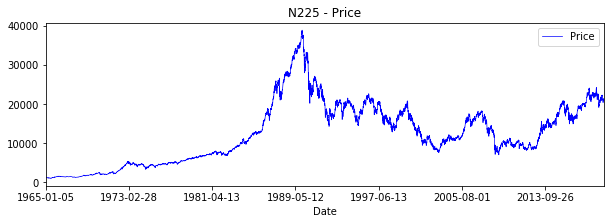

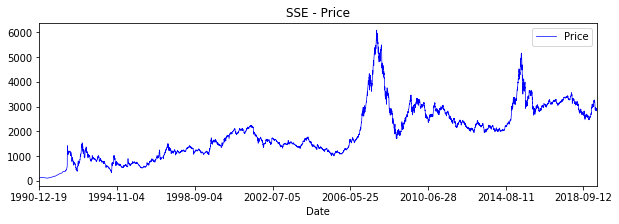

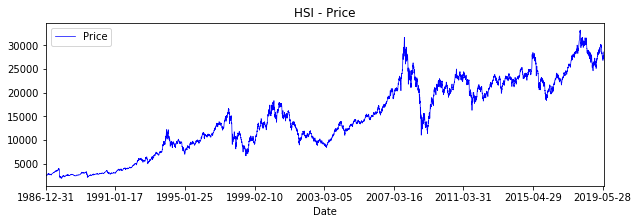

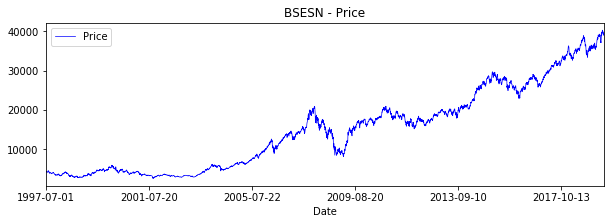

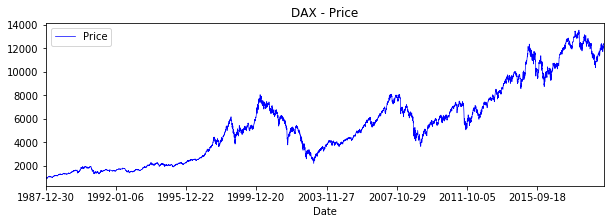

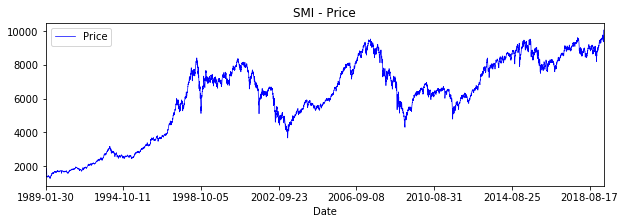

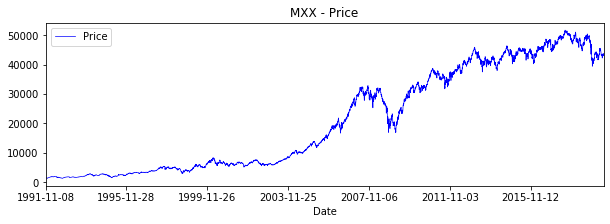

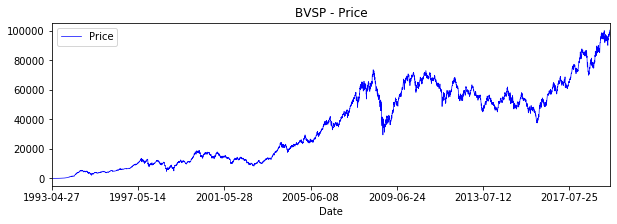

In [7]:
rcParams['figure.figsize'] = 10, 3
plt_titles = ['S&P since 1950', 'N225 since 1965', 'SSE since 1996', 'HSI since 1987', \
              'BSESN since 1997', 'SMI since 1990', 'BVSP since 2002']
for ds in dataset_names_test:
    data = pd.read_csv(path+'/'+ds+'.csv',index_col='Date')
    data['Close'].plot(color='blue', linewidth=0.7)
    plt.legend(['Price'])
    plt.title(ds + ' - Price')
    plt.show()

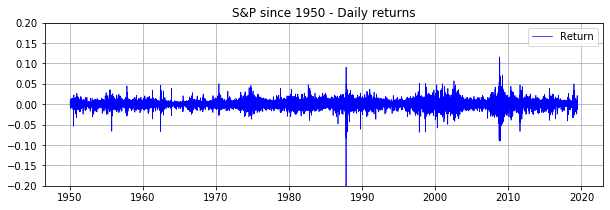

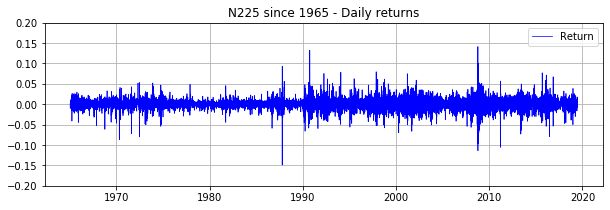

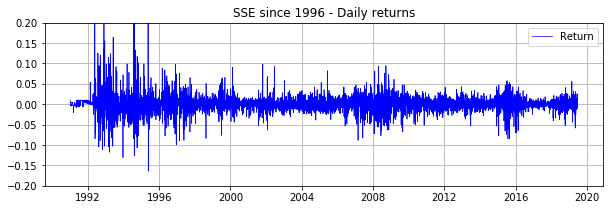

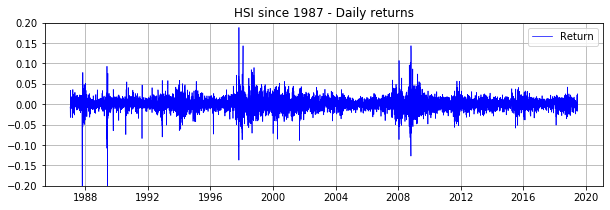

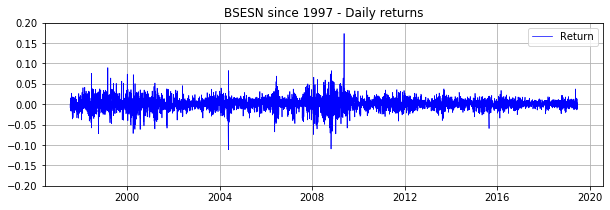

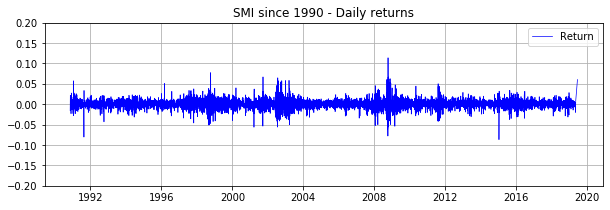

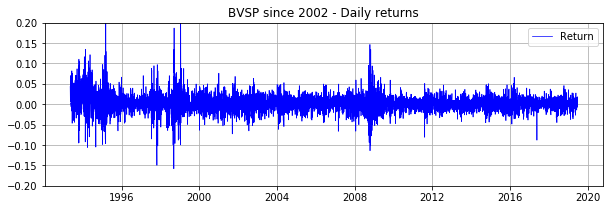

In [8]:
# Plot daily return over time
for ds, t in zip(datasets, plt_titles):
    plt.plot(ds['ch'], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(t + ' - Daily returns')
    plt.show()

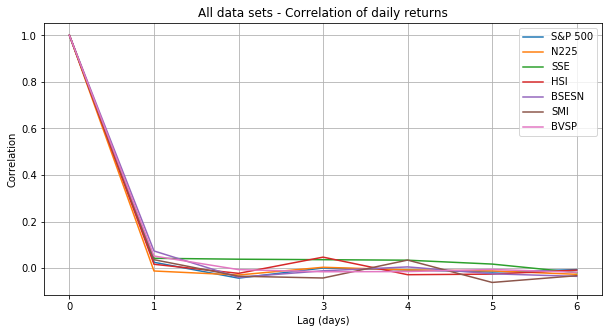

In [9]:
# Autocorrelation
corr_ds = []
rcParams['figure.figsize'] = 10, 5
for ds, t in zip(datasets, plt_titles):
    corr = [1]
    for i in range(1, 7):
        corr.append(np.corrcoef(ds['ch'][i:], ds['ch'][:-i])[0, 1])
    plt.plot(corr)
plt.title('All data sets - Correlation of daily returns')
plt.legend(dataset_names)
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.grid()
plt.show()

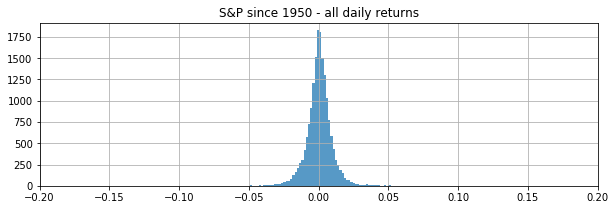

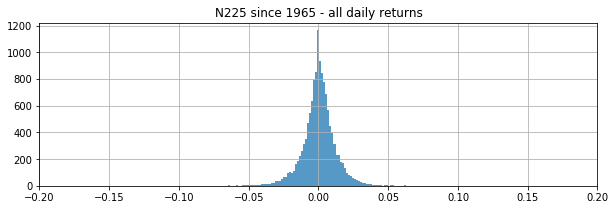

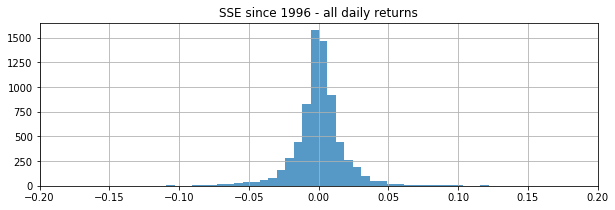

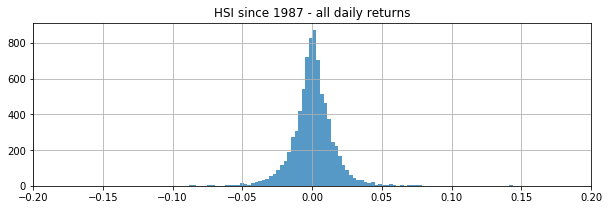

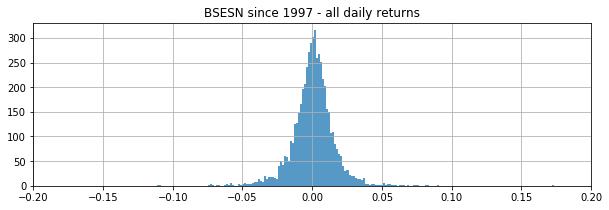

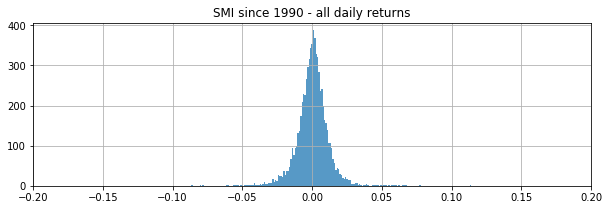

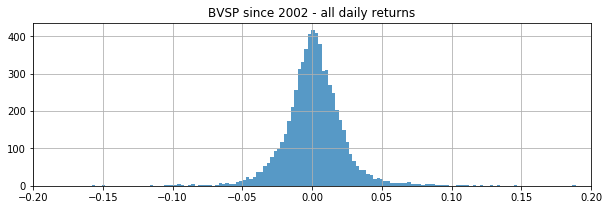

In [10]:
# Plot distribution of daily returns
rcParams['figure.figsize'] = 10, 3
for ds, t in zip(datasets, plt_titles):
    plt.hist(ds['ch'], bins=200, rwidth=1, alpha=0.75)
    plt.xlim(-0.2, 0.2)
    plt.title(t + ' - all daily returns')
    plt.grid()
    plt.show()

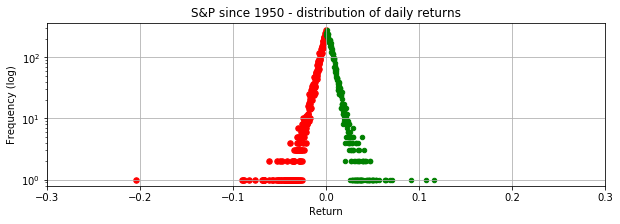

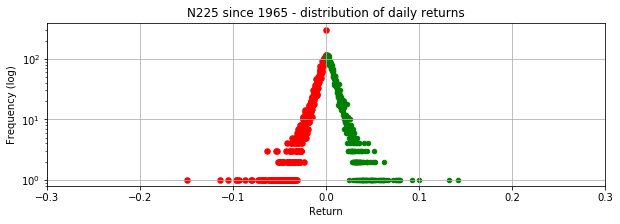

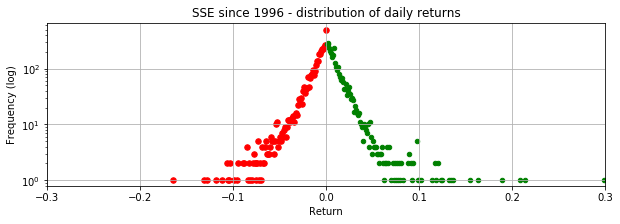

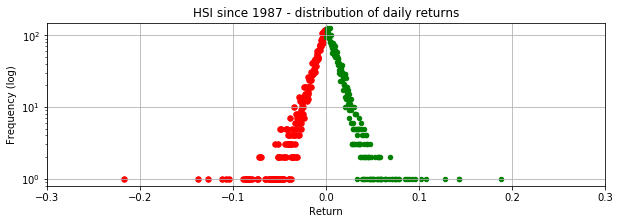

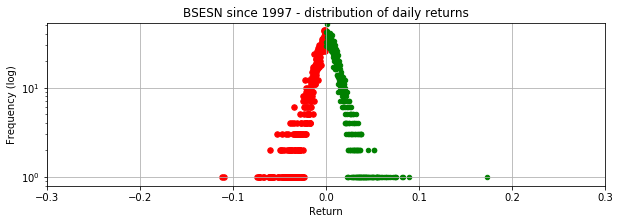

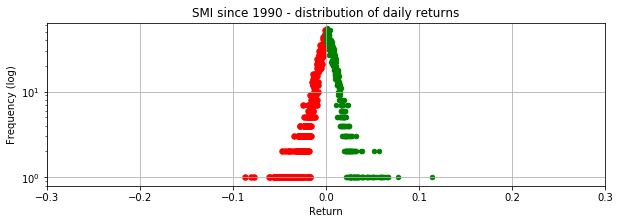

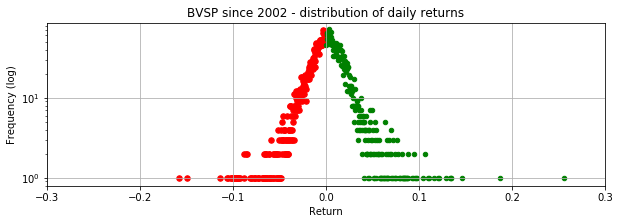

In [11]:
# Plot log-distribution of daily returns
for ds, t in zip(datasets, plt_titles):
    max_return = max(abs(ds['ch']))
    m = round(max_return+0.01,2)
    bins = np.linspace(-m, m, 2000)
    d = {}
    for i in range(1, len(bins)+1):
        d[i] = bins[i-1]
    disc = np.digitize(x=ds['ch'], bins=bins)
    d1 = defaultdict(int)
    for i in disc:
        d1[d[i]] += 1
    df = pd.DataFrame(list(d1.items()))
    df.columns = ['return', 'n']
    df_neg = df[df['return']<0]
    df_neg = df_neg.sort_values(by='return', ascending=True).reset_index(drop=True)
    plt.scatter(df_neg['return'], df_neg['n'], s=30, color='red')
    plt.yscale('log')
    df_neg_reg = df_neg[df_neg['return']>-0.05]
    m, c = np.polyfit(df_neg_reg['return'], np.log(df_neg_reg['n']), 1)
    y_fit = np.exp(m*df_neg['return'] + c)
    plt.ylim(bottom=10**0)
    df_pos = df[df['return']>0]
    df_pos = df_pos.sort_values(by='return', ascending=False).reset_index(drop=True)
    plt.scatter(df_pos['return'], df_pos['n'], s=20, color='green')
    plt.yscale('log')
    df_pos_reg = df_pos[df_pos['return']<0.05]
    m, c = np.polyfit(df_pos_reg['return'], np.log(df_pos_reg['n']), 1)
    y_fit = np.exp(m*df_pos['return'] + c)
    plt.ylim(bottom=10**-0.1)
    plt.xlim(-0.3, 0.3)
    plt.title(t + ' - distribution of daily returns')
    plt.xlabel('Return')
    plt.ylabel('Frequency (log)')
    plt.grid()
    plt.show()
    plt.show()

#### Drawdowns

In [13]:
# Drawdowns
dd_df = []
for ds in datasets:
    pmin_pmax = (ds['price'].diff(-1) > 0).astype(int).diff()
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    dd = (np.array(ds['price'][pmin.index]) - np.array(ds['price'][pmax.index])) \
        / np.array(ds['price'][pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]   # timestrap.date()
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
         'duration': dur}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y-%m-%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    dd_df.append(df_d)

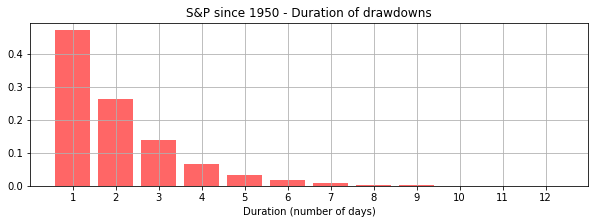

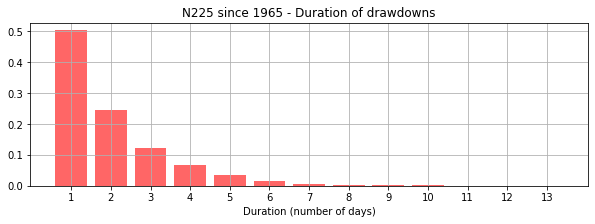

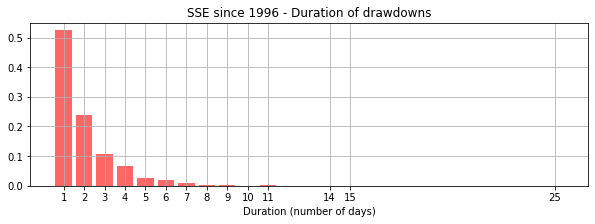

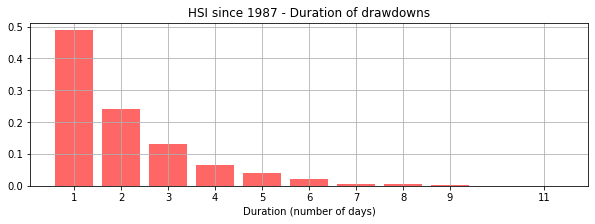

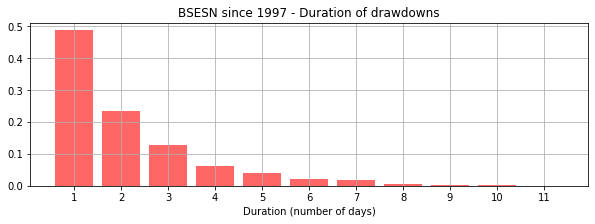

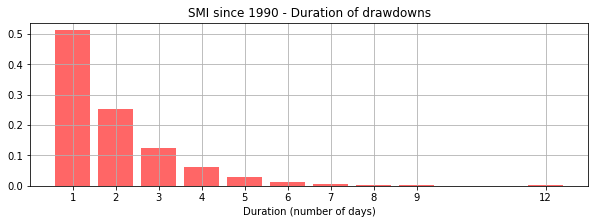

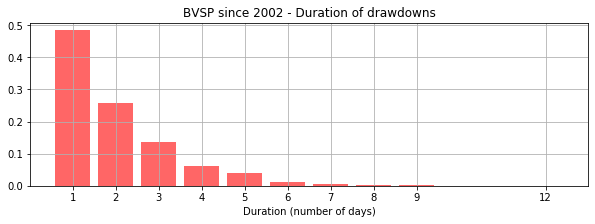

In [14]:
# Plot duration of drawdowns
l_dict_dd = []
for dd, t in zip(dd_df, plt_titles):
    max_dd = max(abs(dd['drawdown']))
    m = round(max_dd+0.01,2)
    bins = np.linspace(-m, m, 800)
    d = {}
    for i in range(1, len(bins)+1):
        d[i] = bins[i-1]
    disc = np.digitize(x=dd['drawdown'], bins=bins)
    d1 = defaultdict(int)
    for i in disc:
        d1[d[i]] += 1
    l_dict_dd.append(d1)
    plt.bar(x=dd['duration'].value_counts().index, height=dd['duration'].\
        value_counts()/dd['duration'].shape[0], color='red', alpha=0.6)
    plt.xticks(dd['duration'].value_counts().index)
    plt.title(t + ' - Duration of drawdowns')
    plt.xlabel('Duration (number of days)')
    plt.grid()
    plt.show()

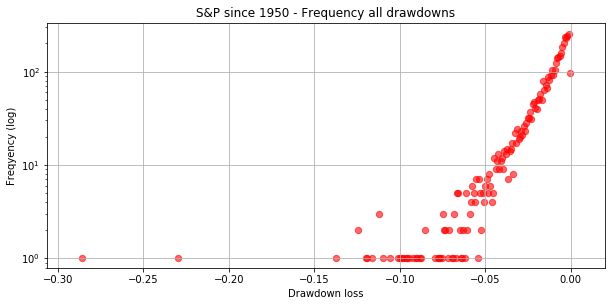

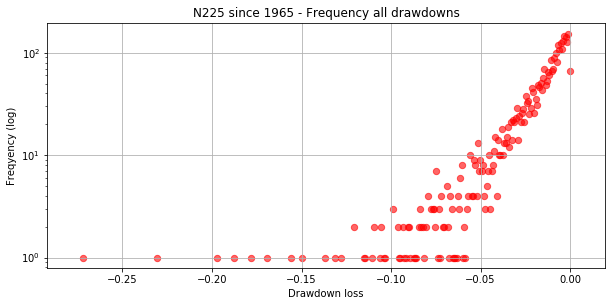

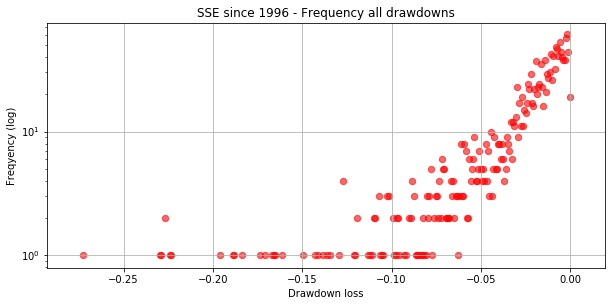

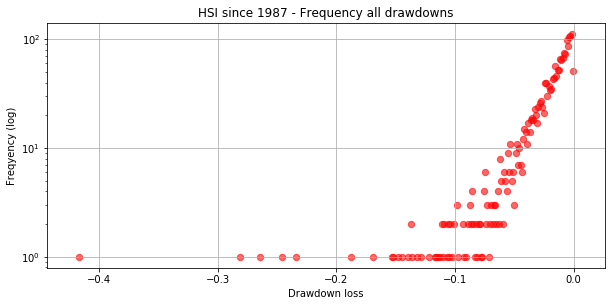

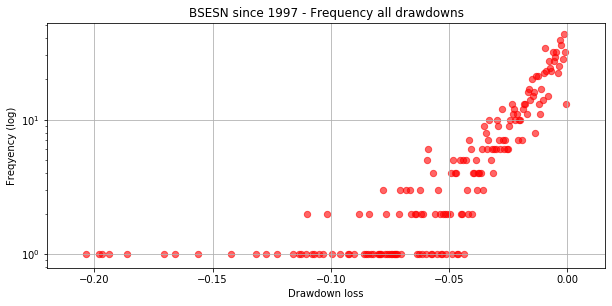

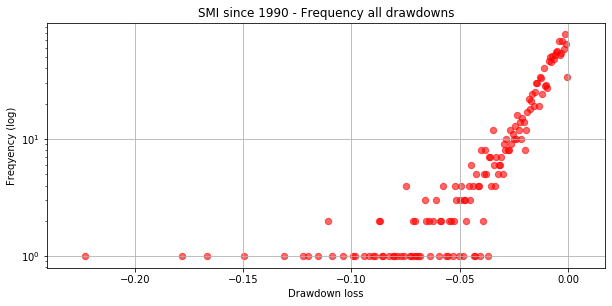

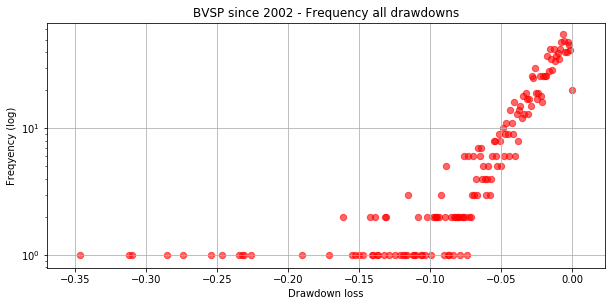

In [15]:
# Plot frequency oof drawdowns
rcParams['figure.figsize'] = 10, 4.5
for d1, t in zip(l_dict_dd, plt_titles):
    df_d_bins = pd.DataFrame(list(d1.items()))
    df_d_bins.columns = ['drawdown', 'n']
    plt.scatter(df_d_bins['drawdown'], df_d_bins['n'], s=40, color='red', alpha=0.6)
    plt.yscale('log')
    df_d_bins_reg = df_d_bins[df_d_bins['drawdown']>-0.08]
    m, c = np.polyfit(df_d_bins_reg['drawdown'], np.log(df_d_bins_reg['n']), 1)
    y_fit = np.exp(m*df_d_bins['drawdown'] + c)
    plt.ylim(bottom=10**-.1)
    #plt.plot(df_d_bins['drawdown'], y_fit, color='black', ls='dashed')
    plt.title(t + ' - Frequency all drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Freqyency (log)')
    plt.grid()
    plt.show()

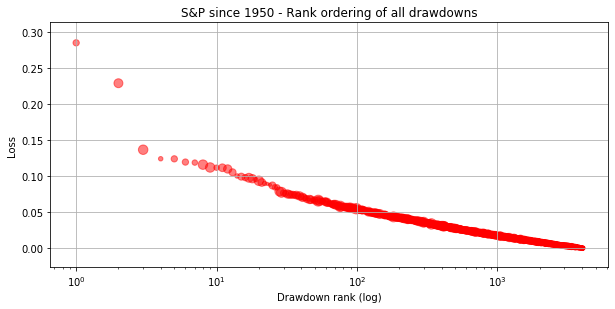

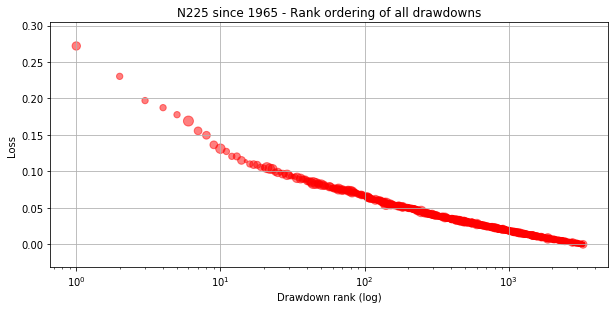

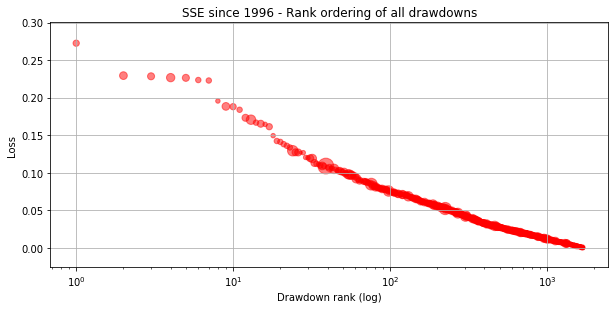

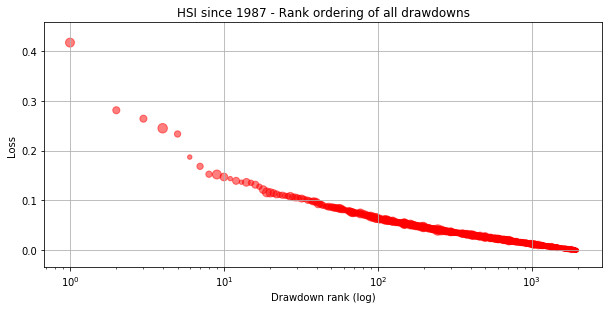

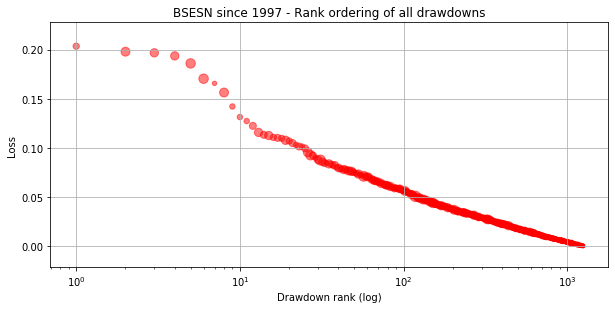

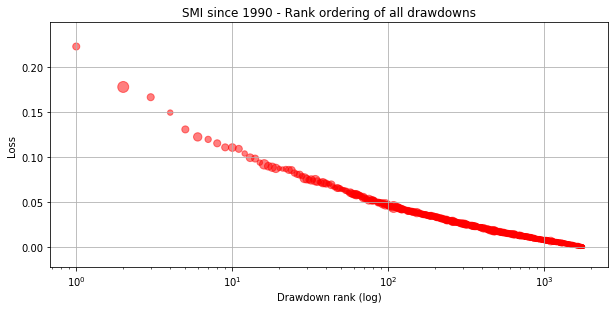

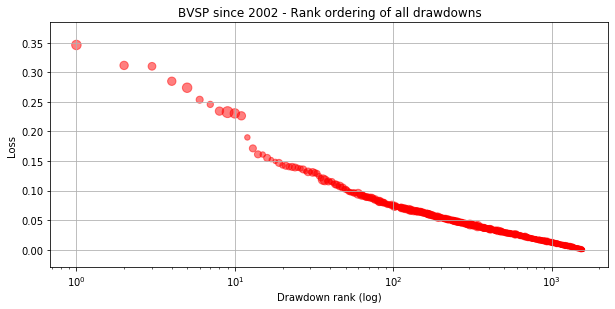

In [16]:
# Drawdown by rank
for dd, t in zip(dd_df, plt_titles):
    plt.scatter(dd['rank'], abs(dd['drawdown']), s=10*dd['duration'], alpha=0.5,\
                color='red')
    plt.xscale('log')
    plt.title(t + ' - Rank ordering of all drawdowns')
    plt.xlabel('Drawdown rank (log)')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

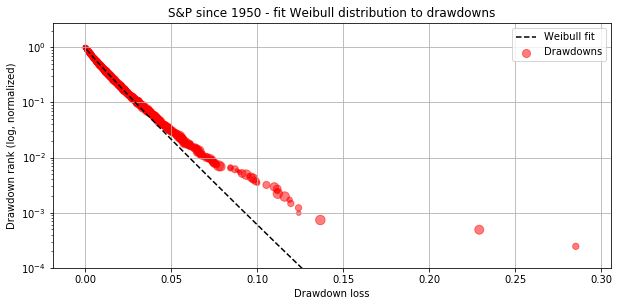

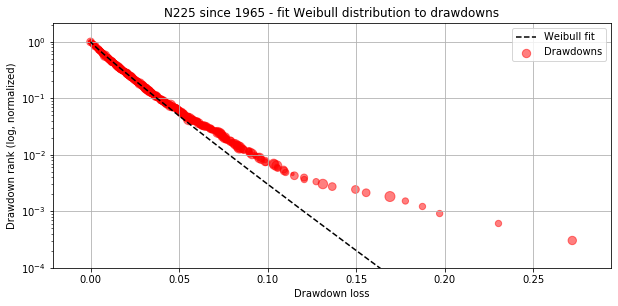

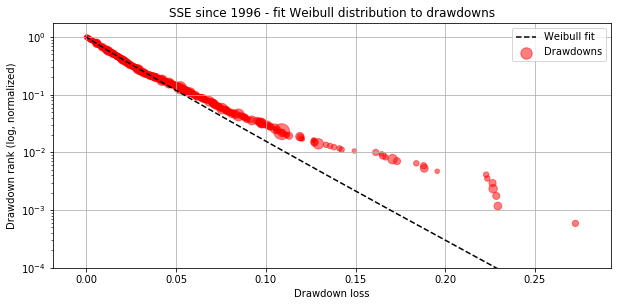

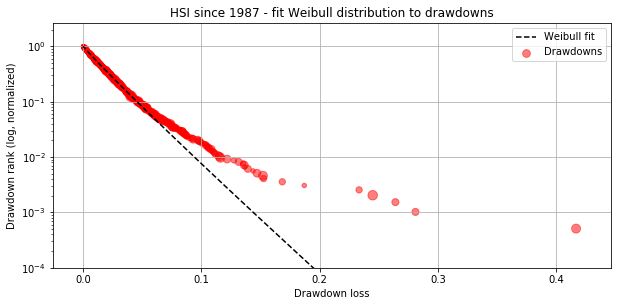

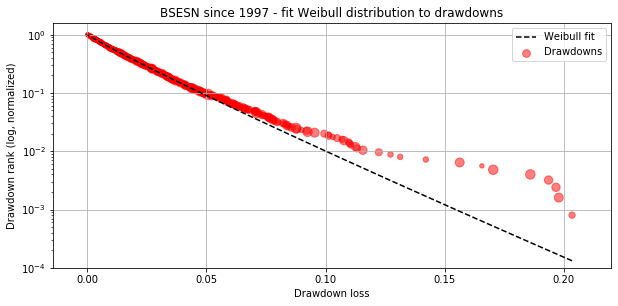

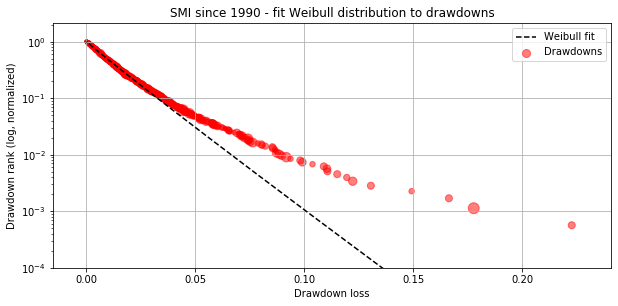

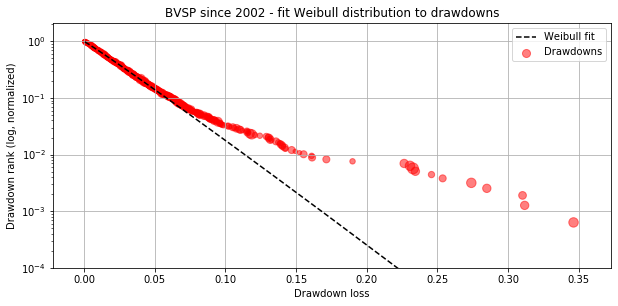

In [19]:
# Fit Weibull exponential function to drawdowns by rank
def weibull(x, chi, z):
    return np.exp(-abs(x/chi)**z)

for dd, t in zip(dd_df, plt_titles):
    x = dd['drawdown']
    y = dd['rank']/dd['rank'].max()
    init_vals = [0.9, 0.015]  # for [z, chi]
    best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
    chi = best_vals[0]
    z = best_vals[1]
    plt.scatter(abs(x), y, s=10*dd['duration'], alpha=0.5, color='red', label='Drawdowns')
    y_fit = [weibull(abs(xi), chi, z) for xi in x]
    plt.plot(abs(x), y_fit, color='black', ls='dashed', label='Weibull fit')
    plt.yscale('log')
    plt.ylim(bottom=10**-4)
    plt.legend()
    plt.title(t + ' - fit Weibull distribution to drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Drawdown rank (log, normalized)')
    plt.grid()
    plt.show()

# Identify Crashes

## Crashes according to Jaccobsen

In [20]:
crash_thresholds = []
for dd in dd_df:
    ct = dd['drawdown'].iloc[round(dd.shape[0] * .005)]
    crash_thresholds.append(ct)

crashes = []
for df, dd, ct in zip(datasets, dd_df, crash_thresholds):
    df_d = dd.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['drawdown'] < ct]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'duration', 'rank']
    crashes.append(df_c)
df_combined = []  
for i in range(len(datasets)):
    df_combined.append(pd.concat([datasets[i], dd_df[i]], axis=1).fillna(0))

for c, t in zip(crashes, plt_titles):
    c['crash_st'] = c['crash_st'].dt.date
    c['crash_end'] = c['crash_end'].dt.date
    c['duration'] = c['duration'].astype(int)
    c['rank'] = c['rank'].astype(int)
    print(t + ' - all crashes (99.5% drawdown quantile):')
    display(c)
    print('\n')

S&P since 1950 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1962-05-15,-0.136724,1962-05-15,1962-05-28,9,3
1974-08-07,-0.097762,1974-08-07,1974-08-19,8,17
1974-09-20,-0.112062,1974-09-20,1974-10-03,9,9
1974-11-11,-0.096474,1974-11-11,1974-11-20,7,18
1980-11-28,-0.093652,1980-11-28,1980-12-11,9,20
1987-10-13,-0.285133,1987-10-13,1987-10-19,4,1
1987-10-21,-0.118856,1987-10-21,1987-10-26,3,7
1997-10-21,-0.098007,1997-10-21,1997-10-27,4,16
1998-08-25,-0.124052,1998-08-25,1998-08-31,4,5




N225 since 1965 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1970-04-24,-0.127345,1970-04-24,1970-04-30,4,11
1971-08-13,-0.197097,1971-08-13,1971-08-19,4,3
1973-11-30,-0.131144,1973-11-30,1973-12-13,9,10
1974-09-25,-0.169037,1974-09-25,1974-10-09,10,6
1987-10-14,-0.177748,1987-10-14,1987-10-20,4,5
1990-03-26,-0.120552,1990-03-26,1990-04-02,5,13
1990-08-15,-0.155609,1990-08-15,1990-08-23,6,7
1990-09-21,-0.149550,1990-09-21,1990-10-01,6,8
1997-01-06,-0.110169,1997-01-06,1997-01-10,4,16




SSE since 1996 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1992-08-07,-0.222854,1992-08-07,1992-08-12,3,7
1992-09-01,-0.229369,1992-09-01,1992-09-09,6,2
1992-10-23,-0.195541,1992-10-23,1992-10-27,2,8
1992-12-03,-0.226392,1992-12-03,1992-12-10,5,5
1993-03-16,-0.226682,1993-03-16,1993-03-25,7,4
1994-04-12,-0.188354,1994-04-12,1994-04-20,6,9
1995-05-22,-0.223496,1995-05-22,1995-05-25,3,6
1996-12-11,-0.272568,1996-12-11,1996-12-17,4,1
2015-08-19,-0.228465,2015-08-19,2015-08-26,5,3




HSI since 1987 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-14,-0.416907,1987-10-14,1987-10-26,8,1
1989-05-29,-0.264112,1989-05-29,1989-06-05,5,3
1992-11-27,-0.168457,1992-11-27,1992-12-03,4,7
1997-10-17,-0.233417,1997-10-17,1997-10-23,4,5
1997-10-24,-0.187037,1997-10-24,1997-10-28,2,6
1997-12-30,-0.244914,1997-12-30,1998-01-12,9,4
2008-09-08,-0.152052,2008-09-08,2008-09-18,8,9
2008-10-02,-0.152620,2008-10-02,2008-10-08,4,8
2008-10-20,-0.281092,2008-10-20,2008-10-27,5,2




BSESN since 1997 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2000-04-11,-0.185957,2000-04-11,2000-04-24,9,5
2001-09-04,-0.170386,2001-09-04,2001-09-17,9,6
2008-01-11,-0.196736,2008-01-11,2008-01-22,7,3
2008-10-01,-0.193619,2008-10-01,2008-10-10,7,4
2008-10-21,-0.203478,2008-10-21,2008-10-27,4,1
2008-11-10,-0.197904,2008-11-10,2008-11-20,8,2




SMI since 1990 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1998-09-28,-0.166382,1998-09-28,1998-10-05,5,3
2001-09-17,-0.119478,2001-09-17,2001-09-21,4,7
2002-07-17,-0.130555,2002-07-17,2002-07-24,5,5
2003-03-03,-0.122230,2003-03-03,2003-03-12,7,6
2008-01-14,-0.110609,2008-01-14,2008-01-21,5,9
2008-10-03,-0.222768,2008-10-03,2008-10-10,5,1
2008-10-20,-0.115113,2008-10-20,2008-10-27,5,8
2011-07-21,-0.177769,2011-07-21,2011-08-08,12,2
2015-01-13,-0.149264,2015-01-13,2015-01-16,3,4




BVSP since 2002 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1995-02-03,-0.273958,1995-02-03,1995-02-16,9,5
1995-02-24,-0.346266,1995-02-24,1995-03-09,9,1
1997-10-21,-0.245774,1997-10-21,1997-10-27,4,7
1998-08-18,-0.234409,1998-08-18,1998-08-27,7,8
1998-09-01,-0.311696,1998-09-01,1998-09-10,7,2
1999-01-06,-0.310190,1999-01-06,1999-01-14,6,3
2008-10-01,-0.284925,2008-10-01,2008-10-10,7,4
2008-10-20,-0.253695,2008-10-20,2008-10-27,5,6


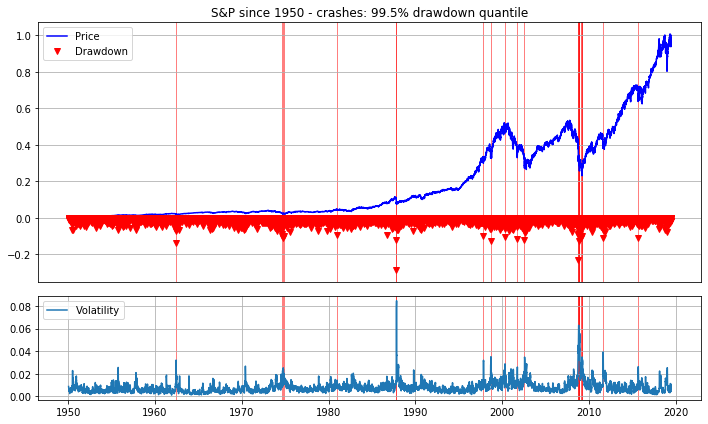

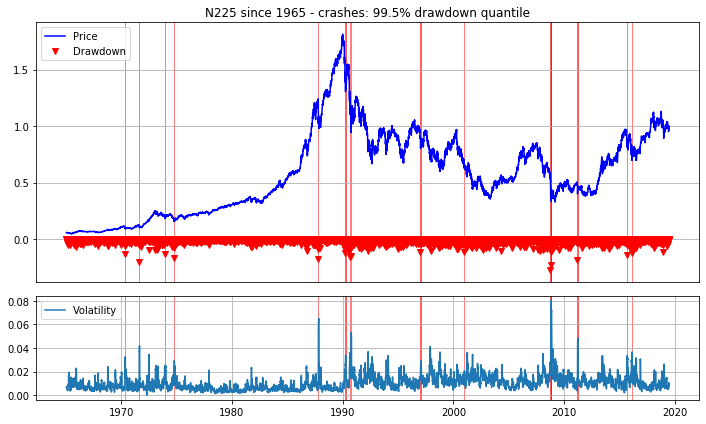

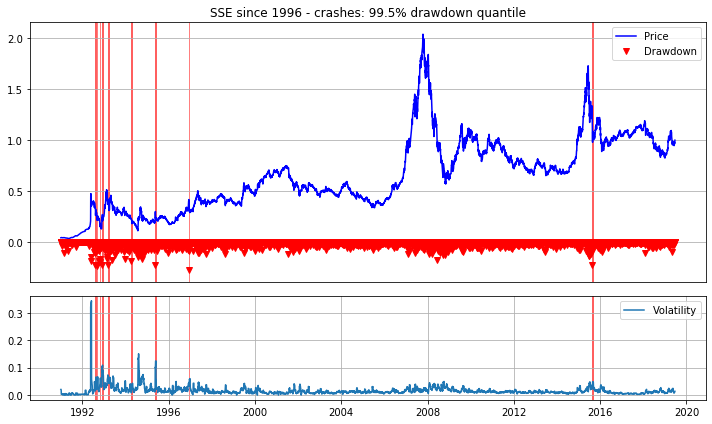

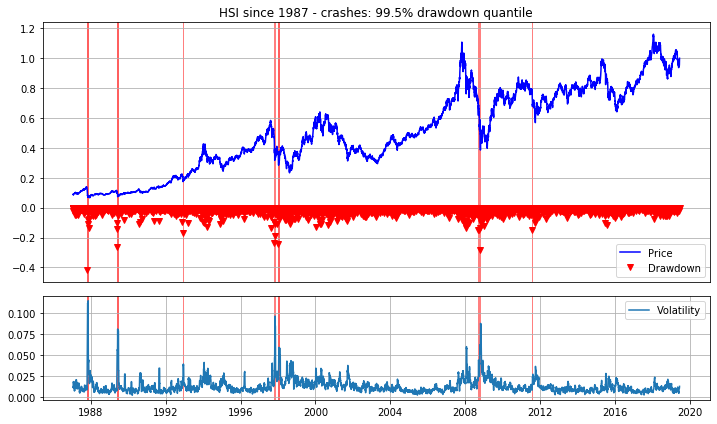

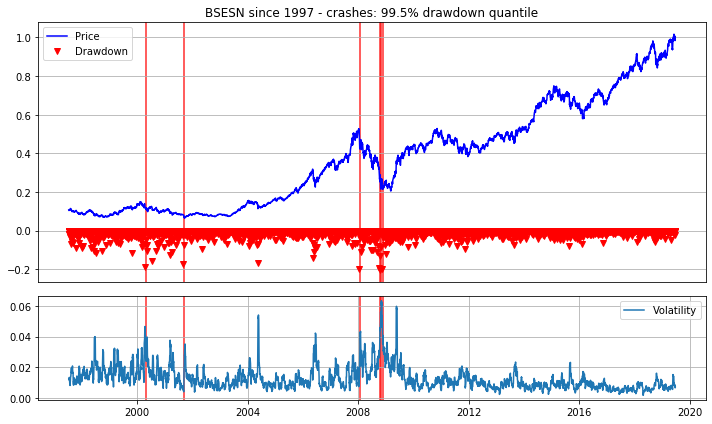

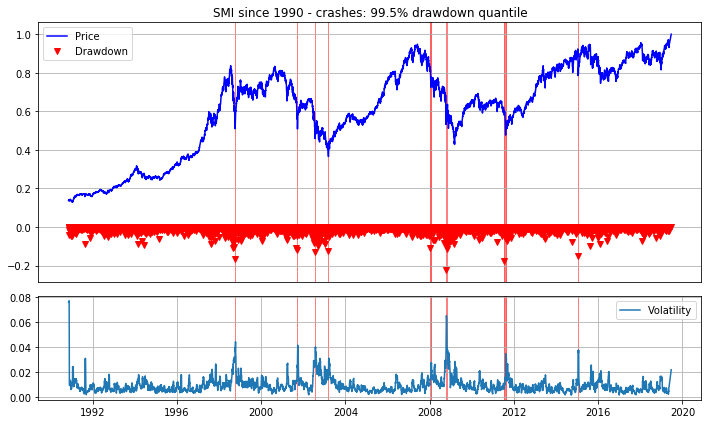

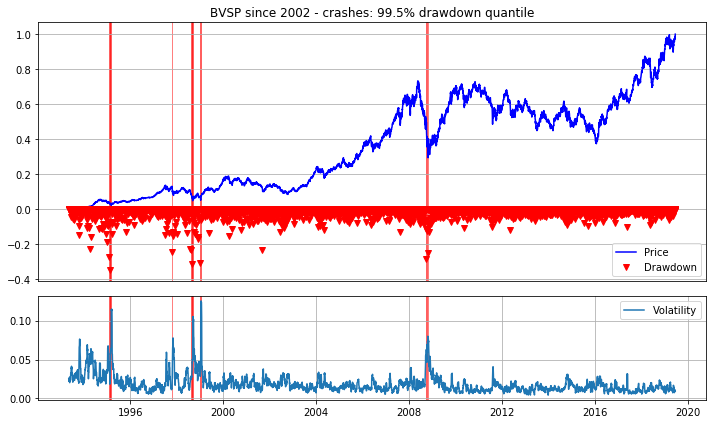

In [21]:
# Plot crashes in time series
rcParams['figure.figsize'] = 10, 6
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i] + ' - crashes: 99.5% drawdown quantile')
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()

## Crashes according to Johansen and Sornette

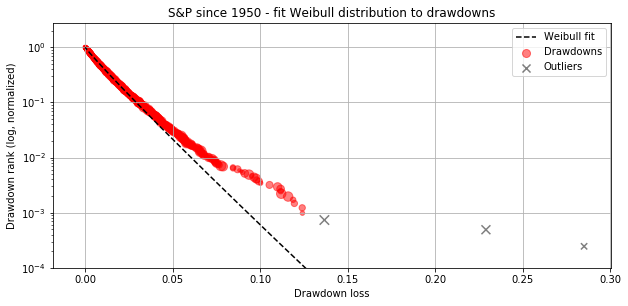

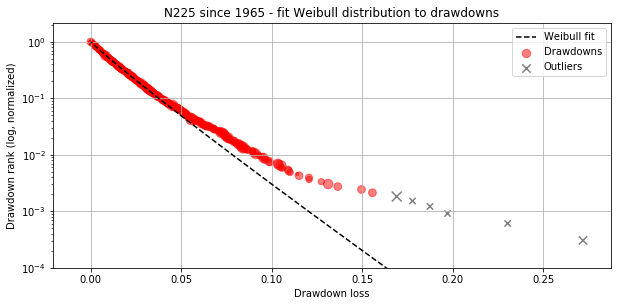

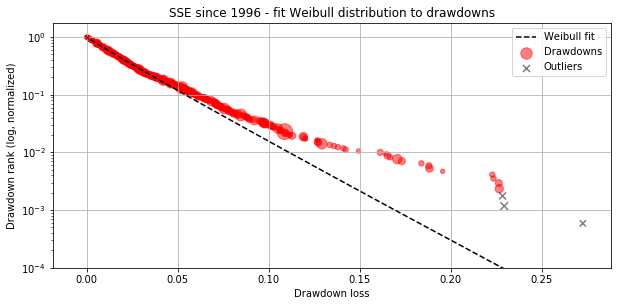

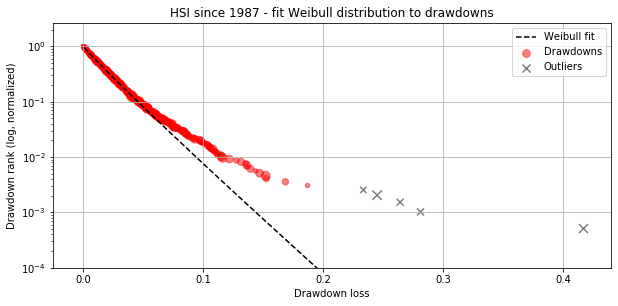

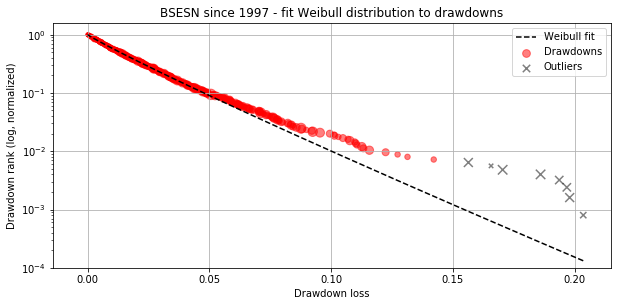

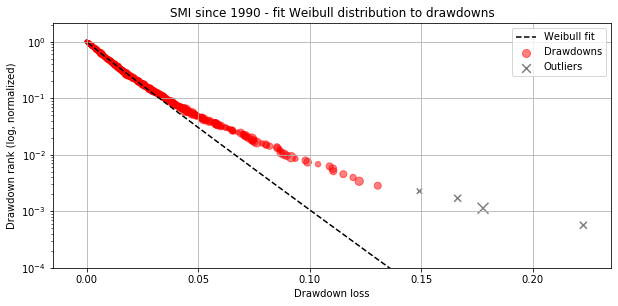

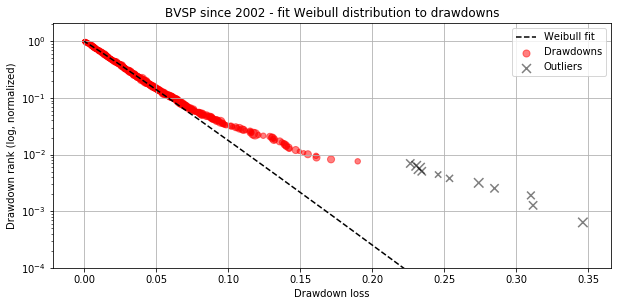

In [25]:
n_crashes = [3, 6, 3, 5, 8, 4, 11]  # number of crashes manually identified based on outliers in Weibul plots below
rcParams['figure.figsize'] = 10, 4.5
for dd, t, n in zip(dd_df, plt_titles, n_crashes):
    x = dd['drawdown']
    y = dd['rank']/dd['rank'].max()
    init_vals = [0.9, 0.015]  # for [z, chi]
    best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
    chi = best_vals[0]
    z = best_vals[1]
    plt.scatter(abs(x[n:]), y[n:], s=10*dd['duration'][n:], alpha=0.5, color='red',label='Drawdowns')
    plt.scatter(abs(x[:n]), y[:n], s=10*dd['duration'][:n], alpha=0.5, color='black', marker='x',label='Outliers')
    y_fit = [weibull(abs(xi), chi, z) for xi in x]
    plt.plot(abs(x), y_fit, color='black', ls='dashed', label='Weibull fit')
    plt.yscale('log')
    plt.ylim(bottom=10**-4)
    plt.legend()
    plt.title(t + ' - fit Weibull distribution to drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Drawdown rank (log, normalized)')
    plt.grid()
    plt.show()

In [27]:
crashes = []
for df, dd, r in zip(datasets, dd_df, n_crashes):
    df_c = dd[dd['rank'] <= r]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'duration', 'rank']
    crashes.append(df_c)

for c, t in zip(crashes, plt_titles):
    c['crash_st'] = c['crash_st'].dt.date
    c['crash_end'] = c['crash_end'].dt.date
    c['duration'] = c['duration'].astype(int)
    c['rank'] = c['rank'].astype(int)
    print(t + ' - all crashes (Weibull outliers):')
    display(c)
    print('\n')

S&P since 1950 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-13,-0.285133,1987-10-13,1987-10-19,4,1
2008-09-30,-0.229037,2008-09-30,2008-10-10,8,2
1962-05-15,-0.136724,1962-05-15,1962-05-28,9,3




N225 since 1965 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2008-10-01,-0.271970,2008-10-01,2008-10-10,7,1
2008-10-21,-0.230313,2008-10-21,2008-10-27,4,2
1971-08-13,-0.197097,1971-08-13,1971-08-19,4,3
2011-03-09,-0.187388,2011-03-09,2011-03-15,4,4
1987-10-14,-0.177748,1987-10-14,1987-10-20,4,5
1974-09-25,-0.169037,1974-09-25,1974-10-09,10,6




SSE since 1996 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1996-12-11,-0.272568,1996-12-11,1996-12-17,4,1
1992-09-01,-0.229369,1992-09-01,1992-09-09,6,2
2015-08-19,-0.228465,2015-08-19,2015-08-26,5,3




HSI since 1987 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-14,-0.416907,1987-10-14,1987-10-26,8,1
2008-10-20,-0.281092,2008-10-20,2008-10-27,5,2
1989-05-29,-0.264112,1989-05-29,1989-06-05,5,3
1997-12-30,-0.244914,1997-12-30,1998-01-12,9,4
1997-10-17,-0.233417,1997-10-17,1997-10-23,4,5




BSESN since 1997 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2008-10-21,-0.203478,2008-10-21,2008-10-27,4,1
2008-11-10,-0.197904,2008-11-10,2008-11-20,8,2
2008-01-11,-0.196736,2008-01-11,2008-01-22,7,3
2008-10-01,-0.193619,2008-10-01,2008-10-10,7,4
2000-04-11,-0.185957,2000-04-11,2000-04-24,9,5
2001-09-04,-0.170386,2001-09-04,2001-09-17,9,6
2004-05-13,-0.165629,2004-05-13,2004-05-17,2,7
2000-07-12,-0.156305,2000-07-12,2000-07-24,8,8




SMI since 1990 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2008-10-03,-0.222768,2008-10-03,2008-10-10,5,1
2011-07-21,-0.177769,2011-07-21,2011-08-08,12,2
1998-09-28,-0.166382,1998-09-28,1998-10-05,5,3
2015-01-13,-0.149264,2015-01-13,2015-01-16,3,4




BVSP since 2002 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1995-02-24,-0.346266,1995-02-24,1995-03-09,9,1
1998-09-01,-0.311696,1998-09-01,1998-09-10,7,2
1999-01-06,-0.310190,1999-01-06,1999-01-14,6,3
2008-10-01,-0.284925,2008-10-01,2008-10-10,7,4
1995-02-03,-0.273958,1995-02-03,1995-02-16,9,5
2008-10-20,-0.253695,2008-10-20,2008-10-27,5,6
1997-10-21,-0.245774,1997-10-21,1997-10-27,4,7
1998-08-18,-0.234409,1998-08-18,1998-08-27,7,8
2001-08-29,-0.232699,2001-08-29,2001-09-14,12,9


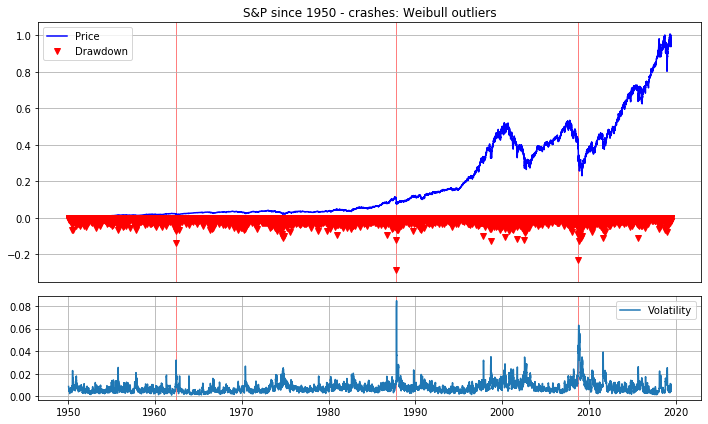

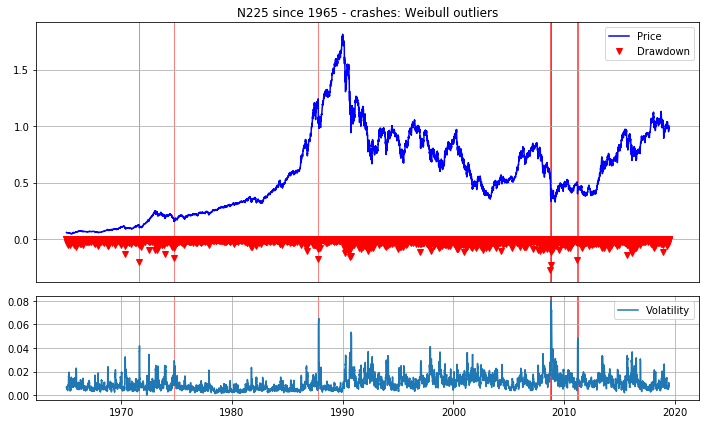

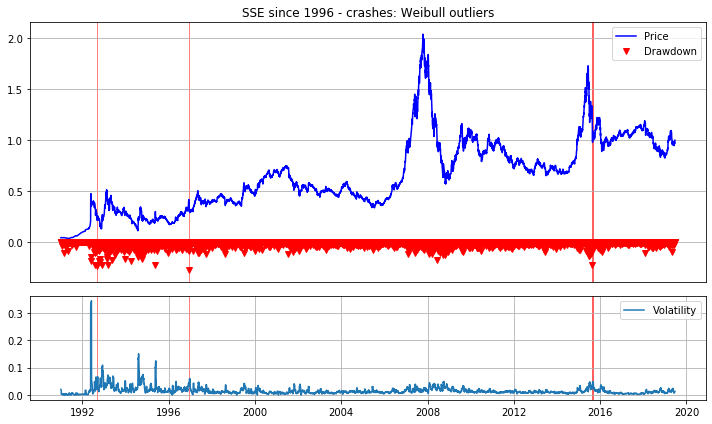

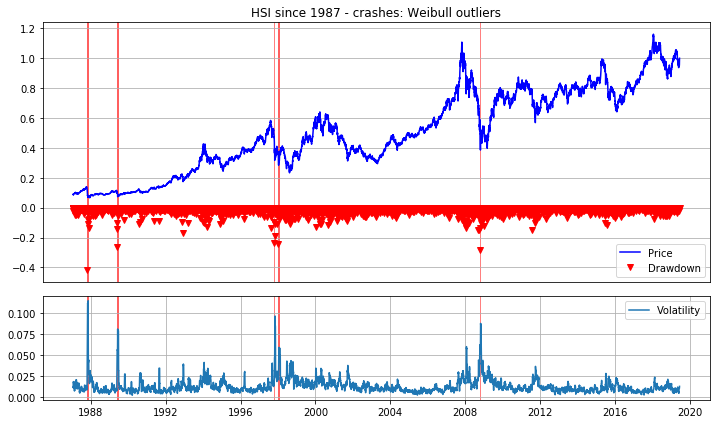

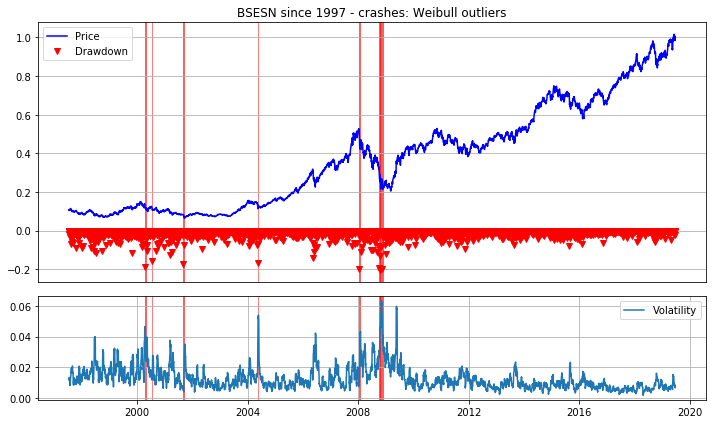

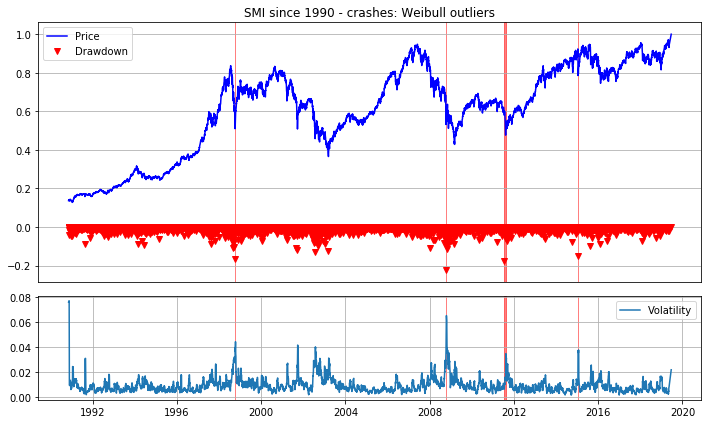

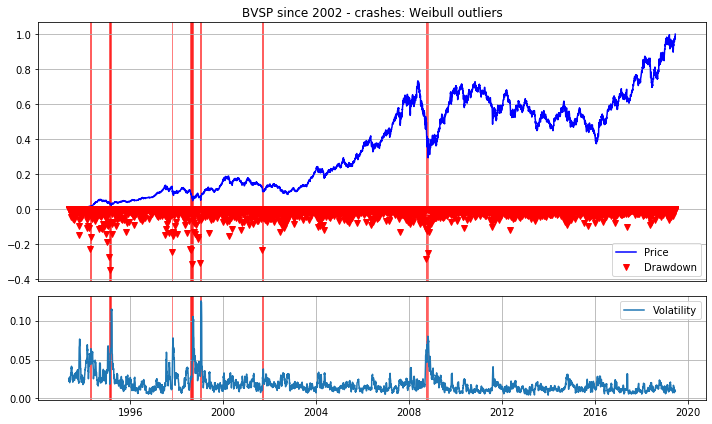

In [28]:
# Plot crashes in time series
rcParams['figure.figsize'] = 10, 6
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i] + ' - crashes: Weibull outliers')
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()